<a href="https://colab.research.google.com/github/alexanderconroy/H.C.-Andersens-eventyr/blob/main/H_C_Andersens_eventyr_Zero_Shot_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biblioteker og pakker

In [ ]:
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.52.2
    Uninstalling openai-1.52.2:
      Successfully uninstalled openai-1.52.2


In [ ]:
import openai

openai.api_key = # fjernet

In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import os

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Indlæs data

Her indlæses eventyrerne, og antallet af tekster tælles, hvorefter data forbebehandles.



In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir_path = "/content/drive/MyDrive/Notebooks_and_data/HCA_eventyr"

filenames = sorted([f for f in os.listdir(dir_path) if f.endswith('.txt')])
len(filenames)

161

Teksterne opdeles i sætninger via NLTK, og de gemmes i en dataframe med filnavnet tilknyttet, som i alt består af 14240 rækker (= sætninger).

In [ ]:
data = []

for filename in filenames:
    file_path = os.path.join(dir_path, filename)

    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()

        sentences = nltk.sent_tokenize(text)

        for sentence in sentences:
            data.append({'filename': filename, 'docs': sentence})

df = pd.DataFrame(data)

In [ ]:
df

,filename,docs
0,aarets-historie.txt,Det var sidst i Januar; en frygtelig Sneestorm...
1,aarets-historie.txt,"Karreeter og Heste vare ligesom overpuddrede, ..."
2,aarets-historie.txt,"Tause stode de, til endelig, efter ligesom en ..."
3,aarets-historie.txt,"Mod Aften var det blikstille, Himlen saae ud, ..."
4,aarets-historie.txt,"»Pip!«\nsagde den ene til den anden, »det kald..."
...,...,...
14235,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,fare hen!
14236,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,Det er Historien om Valdemar Daae og hans Døttre.
14237,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,"Fortæl den bedre, I Andre!"
14238,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,om I kunne det!«\nsagde Vinden og vendte sig.


In [ ]:
# Kontrol af segmenteringen

filename = df["filename"].to_list()
docs = df["docs"].to_list()

print(filename[:3])
print(docs[:3])
print(len(docs))

['aarets-historie.txt', 'aarets-historie.txt', 'aarets-historie.txt']
['Det var sidst i Januar; en frygtelig Sneestorm var det; Sneen fløi i fygende Hvirvel gjennem Gader og Stræder; Ruderne udenpaa vare som overklistrede med Snee, fra Tagene styrtede den i Dynger, og saa var der en Flugt i Folk, de løb, de fløi og foer hinanden i Armene, holdt hinanden fast et Øieblik og havde saalænge Fodfæste.', 'Karreeter og Heste vare ligesom overpuddrede, Tjenerne stode med Ryggen mod Karreeten og kjørte baglænds imod Vinden, Fodgjængeren holdt sig stadigt i Læ af Vognen, der kun langsomt gled afsted i den dybe Snee; og da endelig Stormen lagde sig og der blev kastet en smal Sti langs Husene, saa stod dog Folk stille der, naar de mødtes; ingen af dem havde Lyst til at gjøre det første Skridt, med at træde op i den dybe Snee, for at den Anden kunde slippe forbi.', 'Tause stode de, til endelig, efter ligesom en stille Overeenskomst, hver af dem gav eet Been til Priis og lod dette gaae ind i Sneedyn

Metadata med udgivelsesår indlæses.

In [9]:
metadata = pd.read_csv("/content/drive/MyDrive/Notebooks_and_data/HCA_eventyr_årstal.txt", header=None)
metadata

,0,1
0,doedningen,1830
1,det-sjunkne-kloster,1831
2,fyrtoeiet,1835
3,lille-claus-og-store-claus,1835
4,prindsessen-paa-aerten,1835
...,...,...
156,hvad-gamle-johanne-fortalte,1872
157,portnoeglen,1872
158,kroeblingen,1872
159,tante-tandpine,1872


In [10]:
metadata.rename(columns={0: 'filename', 1: 'årstal'}, inplace=True)
metadata

,filename,årstal
0,doedningen,1830
1,det-sjunkne-kloster,1831
2,fyrtoeiet,1835
3,lille-claus-og-store-claus,1835
4,prindsessen-paa-aerten,1835
...,...,...
156,hvad-gamle-johanne-fortalte,1872
157,portnoeglen,1872
158,kroeblingen,1872
159,tante-tandpine,1872


# Analyse 1: Økonomi

## Zero-Shot Classification

Her benyttes gpt4o-mini til Zero-Shot Classification med den prompt, vi efter flere forsøg fandt bedst egnet til opgaven. I første api-call beder vi modellen om at begrunde de første 300 klassificeringer til inspektion. I det andet api-call klassificerer modellen samtlige tekstsegmenter, men uden begrundelser.

In [ ]:
# Med begrundelser for valg af kategori

results = []

for index, row in df.iterrows():
    if index >= 300:
        break

    segment = row['docs']

    prompt = (
        "Jeg har et datasæt med historisk dansk tekst. Hjælp mig med at identificere de segmenter, der bruger ord knyttet til økonomisk værdi."
        "Vurder hvert segment og vælg den mest relevante kategori blandt følgende og prioritér de fire første kategorier, dvs. hvis segmentet blot er i den mindste berøring med en af fire første kategorier (inkl. metaforer for økonomisk værdi), skal den vælges:\n\n"
        "1. Penge\n"
        "2. Valuta (inklusive ældre valuta)\n"
        "3. Ædelmetaller og andre metaller af værdi\n"
        "4. Andre segmenter, som reflekterer en form for økonomisk værdi \n"
        "5. Ikke relevante segmenter\n\n"
        f"Segment: \"{segment}\"\n\n"
        "Vælg venligst én kategori, som skal nævnes ordret til sidst i hvert svar efter kategori og et kolon:"
    )

    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    category = response['choices'][0]['message']['content'].strip()
    results.append(category)

# Resultatet gemmes i en dataframe
df['label'] = pd.NA
df.loc[:len(results)-1, 'label'] = results

In [ ]:
df

In [ ]:
# Resultatet gemmes som excelfil
df.to_excel("/content/drive/MyDrive/Notebooks_and_data/HCA_økonomi_zeroshot_med_begrundelser.xlsx")

In [ ]:
# Uden begrundelser for valg af kategori

results = []

for index, row in df.iterrows():
#    if index >= 300:
#        break

    segment = row['docs']

    prompt = (
        "Jeg har et datasæt med historisk dansk tekst. Hjælp mig med at identificere de segmenter, der bruger ord knyttet til økonomisk værdi."
        "Vurder hvert segment og vælg den mest relevante kategori blandt følgende og prioritér de fire første kategorier, dvs. hvis segmentet blot er i den mindste berøring med en af fire første kategorier (inkl. metaforer for økonomisk værdi), skal den vælges:\n\n"
        "1. Penge\n"
        "2. Valuta (inklusive ældre valuta)\n"
        "3. Ædelmetaller og andre metaller af værdi\n"
        "4. Andre segmenter, som reflekterer en form for økonomisk værdi \n"
        "5. Ikke relevante segmenter\n\n"
        f"Segment: \"{segment}\"\n\n"
        "Vælg venligst én kategori, som skal nævnes ordret og uden begrundelse for valget:"
    )

    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    category = response['choices'][0]['message']['content'].strip()
    results.append(category)

# Resultatet gemmes i en dataframe
df['label'] = pd.NA
df.loc[:len(results)-1, 'label'] = results

In [ ]:
df

,filename,docs,label
0,aarets-historie.txt,Det var sidst i Januar; en frygtelig Sneestorm...,5. Ikke relevante segmenter
1,aarets-historie.txt,"Karreeter og Heste vare ligesom overpuddrede, ...",5. Ikke relevante segmenter
2,aarets-historie.txt,"Tause stode de, til endelig, efter ligesom en ...","4. Andre segmenter, som reflekterer en form fo..."
3,aarets-historie.txt,"Mod Aften var det blikstille, Himlen saae ud, ...",5. Ikke relevante segmenter
4,aarets-historie.txt,"»Pip!«\nsagde den ene til den anden, »det kald...",5. Ikke relevante segmenter
...,...,...,...
14235,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,fare hen!,5. Ikke relevante segmenter
14236,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,Det er Historien om Valdemar Daae og hans Døttre.,5. Ikke relevante segmenter
14237,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,"Fortæl den bedre, I Andre!",5. Ikke relevante segmenter
14238,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,om I kunne det!«\nsagde Vinden og vendte sig.,5. Ikke relevante segmenter


In [ ]:
# Resultatet gemmes som excel- og csv-fil
df.to_excel("/content/drive/MyDrive/Notebooks_and_data/HCA_økonomi_zeroshot_uden_begrundelser.xlsx")

In [ ]:
df.to_csv("/content/drive/MyDrive/Notebooks_and_data/HCA_økonomi_zeroshot_uden_begrundelser.csv")

## Datarens

In [5]:
data = pd.read_csv("/content/drive/MyDrive/Notebooks_and_data/HCA_økonomi_zeroshot_uden_begrundelser.csv")
data

,Unnamed: 0,filename,docs,label
0,0,aarets-historie.txt,Det var sidst i Januar; en frygtelig Sneestorm...,5. Ikke relevante segmenter
1,1,aarets-historie.txt,"Karreeter og Heste vare ligesom overpuddrede, ...",5. Ikke relevante segmenter
2,2,aarets-historie.txt,"Tause stode de, til endelig, efter ligesom en ...","4. Andre segmenter, som reflekterer en form fo..."
3,3,aarets-historie.txt,"Mod Aften var det blikstille, Himlen saae ud, ...",5. Ikke relevante segmenter
4,4,aarets-historie.txt,"»Pip!«\nsagde den ene til den anden, »det kald...",5. Ikke relevante segmenter
...,...,...,...,...
14235,14235,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,fare hen!,5. Ikke relevante segmenter
14236,14236,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,Det er Historien om Valdemar Daae og hans Døttre.,5. Ikke relevante segmenter
14237,14237,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,"Fortæl den bedre, I Andre!",5. Ikke relevante segmenter
14238,14238,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,om I kunne det!«\nsagde Vinden og vendte sig.,5. Ikke relevante segmenter


In [ ]:
# Overflødigt indeks fjernes
data.pop('Unnamed: 0')

In [7]:
# .txt fjernes fra filnavnene
data['filename'] = data['filename'].str.replace('.txt', '', regex=False)

In [11]:
# Metadata tilkobles
merged_df = pd.merge(data, metadata, on='filename', how='outer')

In [12]:
# Navne på kolonner ændres
merged_df.rename(columns={'filename': 'eventyr', 'docs': 'sætning', 'label': 'kategori'}, inplace=True)

In [13]:
# Navne på kategorier ensrettes

replacements = {
    '1. Valuta (inklusive ældre valuta)': '2. Valuta (inklusive ældre valuta)',
    '4. Andre segmenter, som reflekterer en form for økonomisk værdi.': '4. Andre segmenter, som reflekterer en form for økonomisk værdi',
    '5.ikke relevante segmenter': '5. Ikke relevante segmenter',
    '6. Ikke relevante segmenter': '5. Ikke relevante segmenter',
    'Ikke relevante segmenter': '5. Ikke relevante segmenter',
    'Andre segmenter, som reflekterer en form for økonomisk værdi': '4. Andre segmenter, som reflekterer en form for økonomisk værdi',
    'Fattig Knøs': '4. Andre segmenter, som reflekterer en form for økonomisk værdi',
    'Kategori: 4. Andre segmenter, som reflekterer en form for økonomisk værdi': '4. Andre segmenter, som reflekterer en form for økonomisk værdi',
    'Kategori 4: Andre segmenter, som reflekterer en form for økonomisk værdi': '4. Andre segmenter, som reflekterer en form for økonomisk værdi',
    'Kategori: 4. Andre segmenter, som reflekterer en form for økonomisk værdi': '4. Andre segmenter, som reflekterer en form for økonomisk værdi',
    'Kategori 4: Andre segmenter, som reflekterer en form for økonomisk værdi.': '4. Andre segmenter, som reflekterer en form for økonomisk værdi',
    'Kategori 5: Ikke relevante segmenter': '5. Ikke relevante segmenter',
    'Ædelmetaller og andre metaller af værdi': '3. Ædelmetaller og andre metaller af værdi',
    'Penge': '1. Penge',
    'Ædelmetaller og andre metaller af værdi': '3. Ædelmetaller og andre metaller af værdi',
    'Non relevante segmenter': '5. Ikke relevante segmenter',
    'Kategori: Ikke relevante segmenter': '5. Ikke relevante segmenter',
    'Valuta (inklusive ældre valuta)': '2. Valuta (inklusive ældre valuta)'
}

merged_df['kategori'] = merged_df['kategori'].replace(replacements)

In [14]:
merged_df = merged_df.dropna(subset=['kategori'])

In [15]:
# kontrol af antal kategorier
len(merged_df['kategori'].unique())

5

In [16]:
# Kategori-optælling i datasættet

value_counts = merged_df['kategori'].value_counts()

print(value_counts)

kategori
5. Ikke relevante segmenter                                        12383
4. Andre segmenter, som reflekterer en form for økonomisk værdi     1287
1. Penge                                                             304
3. Ædelmetaller og andre metaller af værdi                           263
2. Valuta (inklusive ældre valuta)                                     3
Name: count, dtype: int64


In [17]:
# Renset dataframe
merged_df

,eventyr,sætning,kategori,årstal
0,aarets-historie,Det var sidst i Januar; en frygtelig Sneestorm...,5. Ikke relevante segmenter,1852
1,aarets-historie,"Karreeter og Heste vare ligesom overpuddrede, ...",5. Ikke relevante segmenter,1852
2,aarets-historie,"Tause stode de, til endelig, efter ligesom en ...","4. Andre segmenter, som reflekterer en form fo...",1852
3,aarets-historie,"Mod Aften var det blikstille, Himlen saae ud, ...",5. Ikke relevante segmenter,1852
4,aarets-historie,"»Pip!«\nsagde den ene til den anden, »det kald...",5. Ikke relevante segmenter,1852
...,...,...,...,...
14237,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,fare hen!,5. Ikke relevante segmenter,1859
14238,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,Det er Historien om Valdemar Daae og hans Døttre.,5. Ikke relevante segmenter,1859
14239,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,"Fortæl den bedre, I Andre!",5. Ikke relevante segmenter,1859
14240,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,om I kunne det!«\nsagde Vinden og vendte sig.,5. Ikke relevante segmenter,1859


In [ ]:
merged_df.to_csv("/content/drive/MyDrive/Notebooks_and_data/HCA_økonomi_zeroshot_renset.csv")

## Lister og visualiseringer

In [18]:
df = pd.read_csv("/content/drive/MyDrive/Notebooks_and_data/HCA_økonomi_zeroshot_renset.csv")

Her tælles de enkelte kategoriers forekomster per år, deres procentmæssige andel udregnes, og resultaterne plottes i grafer.

In [19]:
category_counts = df.groupby(['årstal', 'kategori']).size().unstack(fill_value=0)

category_counts['total'] = category_counts.sum(axis=1)

long_df = category_counts.reset_index().melt(id_vars=['årstal', 'total'], var_name='kategori', value_name='antal')

long_df['procent'] = (long_df['antal'] / long_df['total']) * 100
long_df['procent'] = long_df['procent'].round(2)

long_df

,årstal,total,kategori,antal,procent
0,1830,194,1. Penge,12,6.19
1,1831,28,1. Penge,0,0.00
2,1835,925,1. Penge,54,5.84
3,1836,132,1. Penge,1,0.76
4,1837,313,1. Penge,5,1.60
...,...,...,...,...,...
155,1868,647,5. Ikke relevante segmenter,559,86.40
156,1869,23,5. Ikke relevante segmenter,21,91.30
157,1870,282,5. Ikke relevante segmenter,246,87.23
158,1872,1415,5. Ikke relevante segmenter,1235,87.28


In [20]:
# Her fjernes to af kategorierne
long_df = long_df[long_df['kategori'] != '5. Ikke relevante segmenter']
long_df = long_df[long_df['kategori'] != '2. Valuta (inklusive ældre valuta)']

In [21]:
# Kategorierne omdøbes, før de visualiseres.

kategori_mapping = {
    "1. Penge": "Penge",
    "3. Ædelmetaller og andre metaller af værdi": "Værdifulde metaller",
    "4. Andre segmenter, som reflekterer en form for økonomisk værdi": "Anden økonomisk værdi",
}

long_df["kategori"] = long_df["kategori"].map(kategori_mapping)


In [22]:
long_df

,årstal,total,kategori,antal,procent
0,1830,194,Penge,12,6.19
1,1831,28,Penge,0,0.00
2,1835,925,Penge,54,5.84
3,1836,132,Penge,1,0.76
4,1837,313,Penge,5,1.60
...,...,...,...,...,...
123,1868,647,Anden økonomisk værdi,66,10.20
124,1869,23,Anden økonomisk værdi,2,8.70
125,1870,282,Anden økonomisk værdi,30,10.64
126,1872,1415,Anden økonomisk værdi,144,10.18


Den øverste graf viser et linjediagram med de forskellige kategoriers procentvise andel af datasættet over tid. Den nederste graf viser de samme data, men med en lineær tendenslinje, der illustrerer den generelle udvikling over årene.

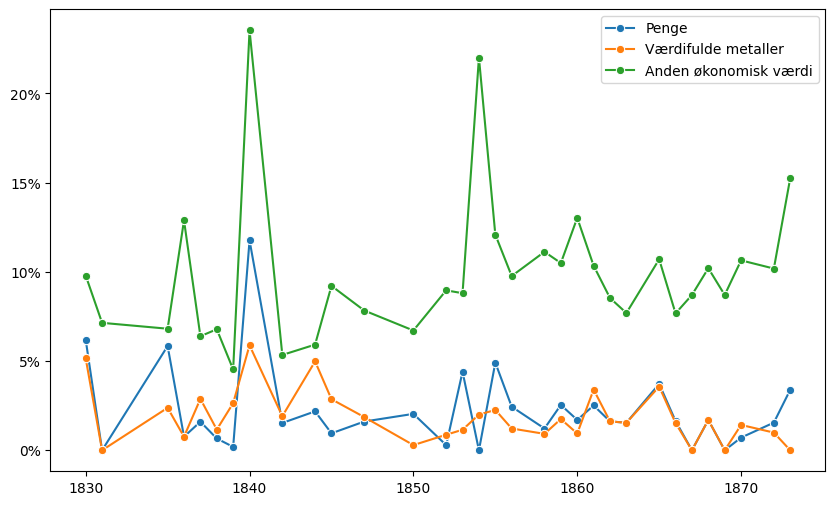

/usr/local/lib/python3.11/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


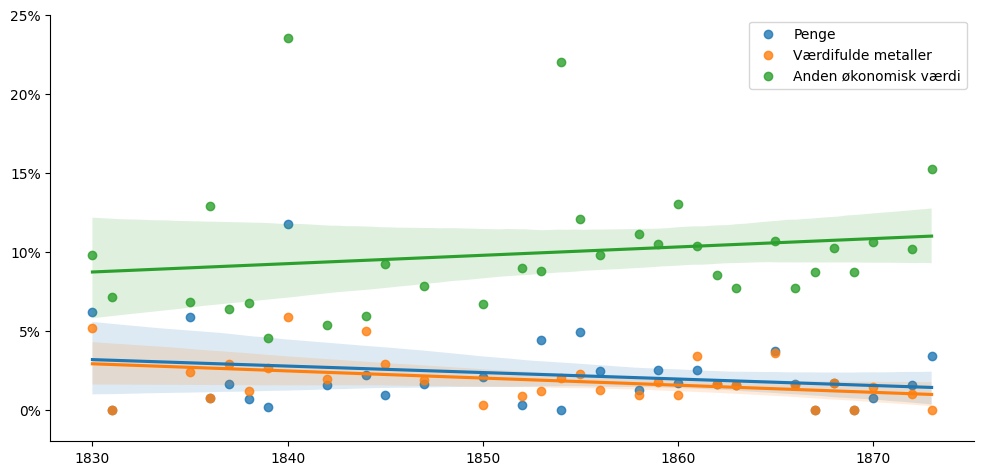

In [23]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=long_df, x='årstal', y='procent', hue='kategori', marker='o')

# Procentformat tilføjes til y-aksen
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.ylabel('')
plt.xlabel('')
plt.legend(title='')
plt.show()

g = sns.lmplot(data=long_df, x='årstal', y='procent', hue='kategori', ci=95, markers='o', aspect=2, legend_out=False)

# Procentformat tilføjes til y-aksen
g.axes[0, 0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.ylim(-2, 25)

plt.ylabel('')
plt.xlabel('')
plt.legend(title='')
plt.show()

Her beregnes de økonomiske segmenters procentmæssige andel af de enkelte eventyr.

In [24]:
# Her etableres en ny kategori (økonomi), der sammenfatter de fire første fra datasættet.

kategori_mapping = {
    "1. Penge": "økonomi",
    "2. Valuta (inklusive ældre valuta)": "økonomi",
    "3. Ædelmetaller og andre metaller af værdi": "økonomi",
    "4. Andre segmenter, som reflekterer en form for økonomisk værdi": "økonomi",
    "5. Ikke relevante segmenter": "ikke relevant"
}

df["ny_kategori"] = df["kategori"].map(kategori_mapping)

resultat = df.groupby(["eventyr", "ny_kategori"]).size().reset_index(name="antal")


In [25]:
resultat

,eventyr,ny_kategori,antal
0,aarets-historie,ikke relevant,93
1,aarets-historie,økonomi,12
2,abc-bogen,ikke relevant,38
3,abc-bogen,økonomi,2
4,aerens-tornevei,ikke relevant,34
...,...,...,...
308,venskabs-pagten,ikke relevant,76
309,venskabs-pagten,økonomi,17
310,verdens-deiligste-rose,ikke relevant,21
311,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,ikke relevant,168


In [26]:
total_counts = resultat.groupby("eventyr")["antal"].transform("sum")

resultat["andel"] = resultat["antal"] / total_counts * 100

In [27]:
resultat

,eventyr,ny_kategori,antal,andel
0,aarets-historie,ikke relevant,93,88.571429
1,aarets-historie,økonomi,12,11.428571
2,abc-bogen,ikke relevant,38,95.000000
3,abc-bogen,økonomi,2,5.000000
4,aerens-tornevei,ikke relevant,34,85.000000
...,...,...,...,...
308,venskabs-pagten,ikke relevant,76,81.720430
309,venskabs-pagten,økonomi,17,18.279570
310,verdens-deiligste-rose,ikke relevant,21,100.000000
311,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,ikke relevant,168,80.382775


Her udregnes den gennemsnitlige procentandel af økonomiske segmenter i de eventyr, som indgår i datasættet (dvs. på baggrund af alle de eventyr, hvor modellen har fundet økonomiske segmenter).

In [29]:
df_økonomi = resultat[resultat["ny_kategori"] == "økonomi"]

gennemsnit_andel_økonomi = df_økonomi["andel"].mean()

print(gennemsnit_andel_økonomi)

14.359069123165977


Her udregnes den procentmæssige andel af økonomiske segmenter på tværs af alle eventyrene i korpusset (dvs. beregningen inkluderer de tekster, der ikke er fundet økonomiske segmenter i).

In [30]:
sum_andele = df_økonomi["andel"].sum()

# Alle tekster i korpusset anføres
total_tekster = 161

justeret_gennemsnit = sum_andele / total_tekster

print(justeret_gennemsnit)

13.734761769984848


# Analyse 2: Fattigdom

## Zero-Shot Classification

Igen benyttes gpt4o-mini til Zero-Shot Classification med den prompt, vi efter flere forsøg fandt bedst egnet til opgaven. Da det her kun drejer sig om to kategorier (fattigdom: ja/nej) – og for at spare på ressourcerne – har vi ikke bedt modellen om at begrunde klassifikationen som ved første api-call i den anden analyse.

In [ ]:
results = []


for index, row in df.iterrows():
#    if index >= 300:
#        break

    segment = row['docs']

    prompt = (
        "Jeg har et datasæt med historisk dansk tekst. Hjælp mig med at identificere de segmenter, der omhandler fattigdom, armod og samfundets udsatte, herunder arbejdere og børn"
        "Vurder hvert segment og vælg den mest relevante kategori blandt følgende og prioritér den første af de to kategorier i tvetydige tilfælde:\n\n"
        "1. Fattigdom\n"
        "2. Ikke relevante segmenter\n\n"
        f"Segment: \"{segment}\"\n\n"
        "Vælg venligst én kategori, som skal nævnes ordret og uden begrundelse for valget:"
    )


    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    category = response['choices'][0]['message']['content'].strip()
    results.append(category)

# Resultatet gemmes i en dataframe
df['label'] = pd.NA
df.loc[:len(results)-1, 'label'] = results

In [ ]:
df

,filename,docs,label
0,aarets-historie.txt,Det var sidst i Januar; en frygtelig Sneestorm...,Ikke relevante segmenter
1,aarets-historie.txt,"Karreeter og Heste vare ligesom overpuddrede, ...",Ikke relevante segmenter
2,aarets-historie.txt,"Tause stode de, til endelig, efter ligesom en ...",Ikke relevante segmenter
3,aarets-historie.txt,"Mod Aften var det blikstille, Himlen saae ud, ...",Ikke relevante segmenter
4,aarets-historie.txt,"»Pip!«\nsagde den ene til den anden, »det kald...",Ikke relevante segmenter
...,...,...,...
14235,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,fare hen!,Ikke relevante segmenter
14236,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,Det er Historien om Valdemar Daae og hans Døttre.,Ikke relevante segmenter
14237,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,"Fortæl den bedre, I Andre!",Ikke relevante segmenter
14238,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,om I kunne det!«\nsagde Vinden og vendte sig.,Ikke relevante segmenter


In [ ]:
# Resultatet gemmes som excel- og csv-fil
df.to_csv("/content/drive/MyDrive/Notebooks_and_data/HCA_zeroshot_fattigdom.csv")

In [ ]:
df.to_excel("/content/drive/MyDrive/Notebooks_and_data/HCA_zeroshot_fattigdom.xlsx")

##Datarens

In [32]:
df = pd.read_csv("/content/drive/MyDrive/Notebooks_and_data/HCA_zeroshot_fattigdom.csv")
df

,Unnamed: 0,filename,docs,label
0,0,aarets-historie.txt,Det var sidst i Januar; en frygtelig Sneestorm...,Ikke relevante segmenter
1,1,aarets-historie.txt,"Karreeter og Heste vare ligesom overpuddrede, ...",Ikke relevante segmenter
2,2,aarets-historie.txt,"Tause stode de, til endelig, efter ligesom en ...",Ikke relevante segmenter
3,3,aarets-historie.txt,"Mod Aften var det blikstille, Himlen saae ud, ...",Ikke relevante segmenter
4,4,aarets-historie.txt,"»Pip!«\nsagde den ene til den anden, »det kald...",Ikke relevante segmenter
...,...,...,...,...
14235,14235,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,fare hen!,Ikke relevante segmenter
14236,14236,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,Det er Historien om Valdemar Daae og hans Døttre.,Ikke relevante segmenter
14237,14237,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,"Fortæl den bedre, I Andre!",Ikke relevante segmenter
14238,14238,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,om I kunne det!«\nsagde Vinden og vendte sig.,Ikke relevante segmenter


In [ ]:
# Overflødigt indeks fjernes

df.pop('Unnamed: 0')

In [34]:
# .txt fjernes fra filnavnene
df['filename'] = df['filename'].str.replace('.txt', '', regex=False)

In [35]:
# Metadata tilkobles
merged_df = pd.merge(df, metadata, on='filename', how='outer')

In [36]:
# Navne på kolonner ændres
merged_df.rename(columns={'filename': 'eventyr', 'docs': 'sætning', 'label': 'kategori'}, inplace=True)

In [37]:
# Navne på kategorier ensrettes

replacements = {
    '1. Fattigdom': 'Fattigdom',
    '2. Ikke relevante segmenter': 'Ikke-relevante segmenter',
    'Ikke relevante segmenter': 'Ikke-relevante segmenter',
    'ikke relevante segmenter': 'Ikke-relevante segmenter',
    'IKKE RELEVANTE SEGMENTER': 'Ikke-relevante segmenter',

}

merged_df['kategori'] = merged_df['kategori'].replace(replacements)

In [38]:
# Kategori-optælling i datasættet

value_counts = merged_df['kategori'].value_counts()

print(value_counts)

kategori
Ikke-relevante segmenter    12917
Fattigdom                    1323
Name: count, dtype: int64


In [39]:
# Renset dataframe
merged_df

,eventyr,sætning,kategori,årstal
0,aarets-historie,Det var sidst i Januar; en frygtelig Sneestorm...,Ikke-relevante segmenter,1852
1,aarets-historie,"Karreeter og Heste vare ligesom overpuddrede, ...",Ikke-relevante segmenter,1852
2,aarets-historie,"Tause stode de, til endelig, efter ligesom en ...",Ikke-relevante segmenter,1852
3,aarets-historie,"Mod Aften var det blikstille, Himlen saae ud, ...",Ikke-relevante segmenter,1852
4,aarets-historie,"»Pip!«\nsagde den ene til den anden, »det kald...",Ikke-relevante segmenter,1852
...,...,...,...,...
14237,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,fare hen!,Ikke-relevante segmenter,1859
14238,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,Det er Historien om Valdemar Daae og hans Døttre.,Ikke-relevante segmenter,1859
14239,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,"Fortæl den bedre, I Andre!",Ikke-relevante segmenter,1859
14240,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,om I kunne det!«\nsagde Vinden og vendte sig.,Ikke-relevante segmenter,1859


In [40]:
# Det rensede datasæt gemmes som csv-fil
merged_df.to_csv("/content/drive/MyDrive/Notebooks_and_data/HCA_zeroshot_fattigdom_renset.csv")

## Lister og visualiseringer

Her følges (næsten) samme procedure som i den første analyse med optælling, visualisering og beregning af gennemsnit.

In [41]:
df = pd.read_csv("/content/drive/MyDrive/Notebooks_and_data/HCA_zeroshot_fattigdom_renset.csv")

In [42]:
category_counts = df.groupby(['årstal', 'kategori']).size().unstack(fill_value=0)

category_counts['Total'] = category_counts.sum(axis=1)

long_df = category_counts.reset_index().melt(id_vars=['årstal', 'Total'], var_name='kategori', value_name='Count')

long_df['Procent'] = (long_df['Count'] / long_df['Total']) * 100
long_df['Procent'] = long_df['Procent'].round(2)

long_df

,årstal,Total,kategori,Count,Procent
0,1830,194,Fattigdom,21,10.82
1,1831,28,Fattigdom,1,3.57
2,1835,925,Fattigdom,97,10.49
3,1836,132,Fattigdom,14,10.61
4,1837,313,Fattigdom,15,4.79
...,...,...,...,...,...
59,1868,647,Ikke-relevante segmenter,591,91.34
60,1869,23,Ikke-relevante segmenter,22,95.65
61,1870,282,Ikke-relevante segmenter,253,89.72
62,1872,1415,Ikke-relevante segmenter,1283,90.67


In [43]:
# Her fjernes de ikke relevante segmenter
new_df = long_df[long_df['kategori'] != 'Ikke-relevante segmenter']

Den øverste graf viser et linjediagram med kategorien fattigdoms procentvise andel af datasættet over tid. Den nederste graf viser de samme data, men med en lineær tendenslinje, der illustrerer "udviklingen".

<ipython-input-44-93c74ff9af84>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='')


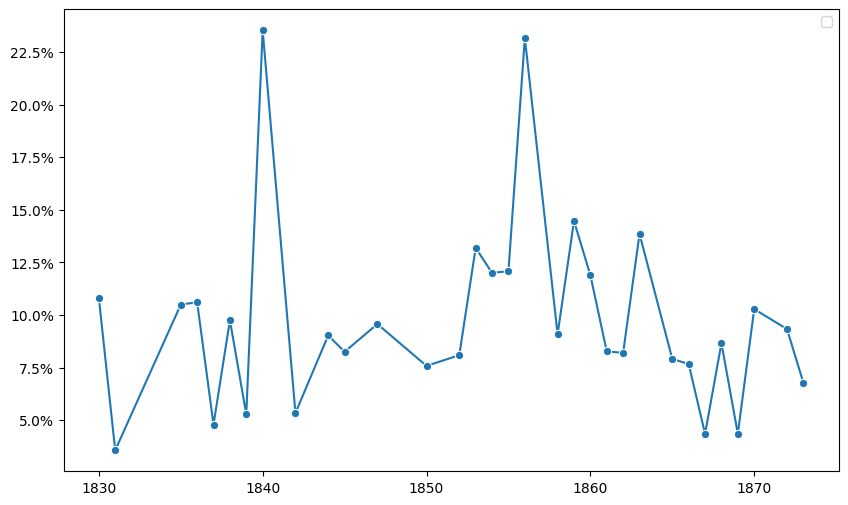

<ipython-input-44-93c74ff9af84>:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='')


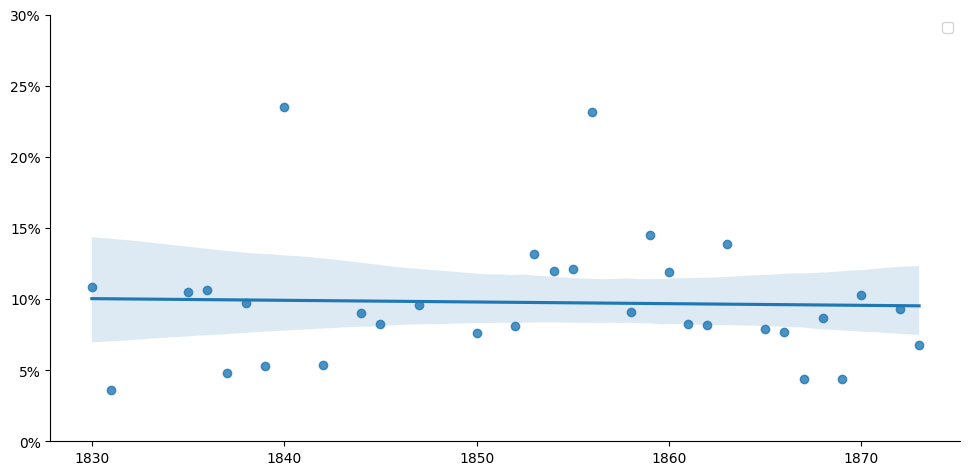

In [44]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=new_df, x='årstal', y='Procent', marker='o')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))

plt.ylabel('')
plt.xlabel('')
plt.legend(title='')
plt.show()

g = sns.lmplot(data=new_df, x='årstal', y='Procent', ci=95, markers='o', aspect=2)

g.axes[0, 0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.ylim(0, 30)

plt.ylabel('')
plt.xlabel('')
plt.legend(title='')
plt.show()

Her beregnes fattigdomssegmenternes procentmæssige andel af de enkelte eventyr.

In [45]:
resultat = df.groupby(["eventyr", "kategori"]).size().reset_index(name="Antal")

total_counts = resultat.groupby("eventyr")["Antal"].transform("sum")

resultat["Andel"] = resultat["Antal"] / total_counts * 100

In [46]:
resultat

,eventyr,kategori,Antal,Andel
0,aarets-historie,Fattigdom,4,3.809524
1,aarets-historie,Ikke-relevante segmenter,101,96.190476
2,abc-bogen,Fattigdom,3,7.500000
3,abc-bogen,Ikke-relevante segmenter,37,92.500000
4,aerens-tornevei,Fattigdom,6,15.000000
...,...,...,...,...
303,venskabs-pagten,Ikke-relevante segmenter,82,88.172043
304,verdens-deiligste-rose,Fattigdom,1,4.761905
305,verdens-deiligste-rose,Ikke-relevante segmenter,20,95.238095
306,vinden-fortaeller-om-valdemar-daae-og-hans-doe...,Fattigdom,30,14.354067


Her udregnes den gennemsnitlige procentandel af fattigdomssegmenter i de eventyr, som indgår i datasættet (dvs. på baggrund af alle de eventyr, hvor modellen har fundet fattigdomssegmenter).

In [47]:
df_fattigdom = resultat[resultat["kategori"] == "Fattigdom"]

mean_andel_fattigdom = df_fattigdom["Andel"].mean()

print(mean_andel_fattigdom)

10.683419627675589


Her udregnes den procentmæssige andel fattigdomssegmenter på tværs af alle eventyrene i korpusset (dvs. beregningen inkluderer de tekster, der ikke er fundet fattigdomssegmenter i).

In [48]:
sum_andele = df_fattigdom["Andel"].sum()

total_tekster = 161

justeret_gennemsnit = sum_andele / total_tekster

print(justeret_gennemsnit)

9.887139903873681
